|Assignment  Step |		Index |	Experiment# |	Dataset A |	Dataset B|
|---|---|---|---|---|---|
|1		|	1 |	1	|	kmeans(A)	| kmeans(B) |
|1		|	2 | 3	|	em(A)	|	em(B)  |
|2		|	3 |	5	|	PCA(A)	|	PCA(B) |
|2		|	4 |	7	|	ICA(A)	|	ICA(B) |
|2		|	5 |	9	|	RP(A)	|	RP(B) |
|2		|	6 |	11	|	CYO(A)	|	CYO(B) |
|3		|	7 |	13	|	kmeans(PCA(A)) |	kmeans(PCA(B)) |
|3		|	8 |	15	|	kmeans(ICA(A)) |	kmeans(ICA(B)) |
|3		|	9 |	17	|	kmeans(RP(A)) |	kmeans(RP(B)) |
|3		|	10 |	19	|	kmeans(CYO(A)) |	kmeans(CYO(B)) |
|3		|	11 |	21	|	em(PCA(A)) |	em(PCA(B)) |
|3		|	12 |	23	|	em(ICA(A)) |	em(ICA(B)) |
|3		|	13 |	25	|	em(RP(A)) |	em(RP(B)) |
|3		|	14 |	27	|	em(CYO(A)) |	em(CYO(B)) |
|4		|	15	 | 29	|	Nnet(PCA(A)) |     |
|4		|	16 |	30	|	Nnet(ICA(A))  |   |
|4		|	17 |	31	|	Nnet(RP(A)) | |
|4		|	18 |	32	|	Nnet(CYO(A)) |  |
|5		|	19 |	33	|	Nnet(kmeans(A)) | |   
|5		|	20 |	34	|	Nnet(em(A))  | |

In [118]:
# set plots inline for ipython
%matplotlib inline

# general python imports
from time import time

# Standard scientific Python imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

# import datasets, preprocessing
from sklearn import datasets, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.image import grid_to_graph

# clustering
from sklearn.cluster import KMeans
from sklearn.mixture import GMM

# dimensionality reduction
from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection 
from sklearn.cluster import FeatureAgglomeration

# import the neural network stuff
from sknn.mlp import Classifier, Layer

In [187]:
# globals
n_row, n_col = 2, 5
n_components = n_row * n_col

In [190]:
# function to plot different decompositions of the data
def plot_gallery(title, images, n_col=n_col, n_row=n_row, image_shape = (64, 64)):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

In [37]:
# Load datasets
digits = datasets.load_digits()
faces = datasets.fetch_olivetti_faces(shuffle = True)

# normalize digits
digits_X = StandardScaler().fit_transform(digits.data)

# normalize olvetti faces
faces_X = StandardScaler().fit_transform(faces.data)

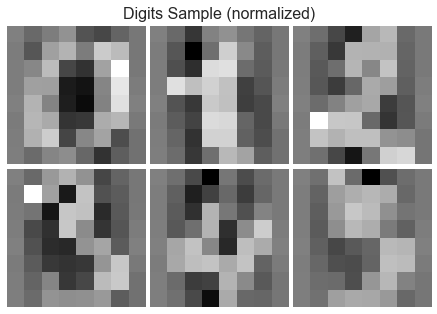

In [45]:
# show example digits
plot_gallery("Digits Sample (normalized)", digits_X[:n_components], image_shape=(8,8))

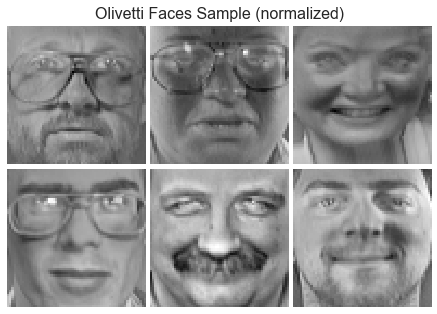

In [38]:
# show some example faces
plot_gallery("Olivetti Faces Sample (normalized)", faces_X[:n_components])

In [188]:
# digit clustering list
clustering_algs = [
    ('K-Means', KMeans(n_clusters=n_components)),
    ('Expectation Maximization', GMM(n_components=n_components))
]

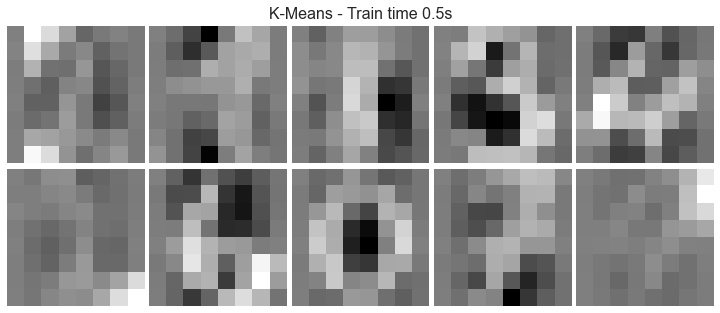

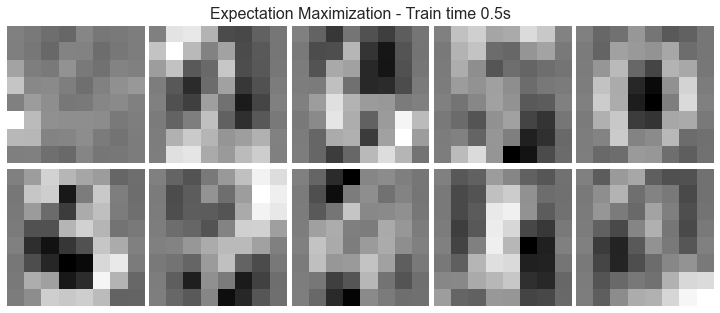

In [191]:
for title, clustering in clustering_algs:
    t0 = time()
    clustering.fit(digits_X)
    train_time = (time() - t0)

    if hasattr(clustering, 'means_'):
        components = clustering.means_
    elif hasattr(clustering, 'cluster_centers_'):
        components = clustering.cluster_centers_
    
    plot_gallery('%s - Train time %.1fs' % (title, train_time),
                 components[:n_components], image_shape=(8,8))

In [192]:
# dimensionality reduction algorithms list
decompositions = [
    ('Principal Components Analysis', PCA(n_components=n_components, whiten=True)),
    ('Independent Components Analysis', FastICA(n_components=n_components, whiten=True)),
    ('Gaussian Random Projections', GaussianRandomProjection(n_components=n_components)),
    ('Feature Agglomeration', FeatureAgglomeration(n_clusters=32))
]

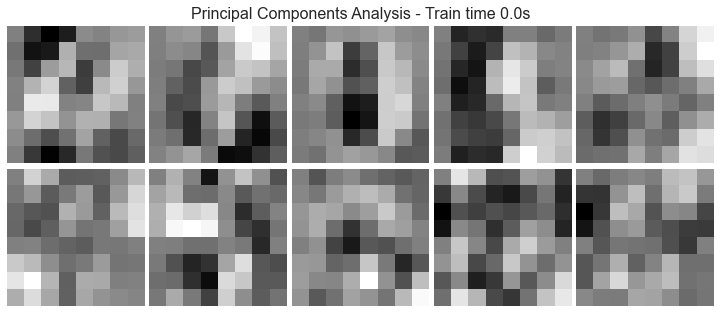

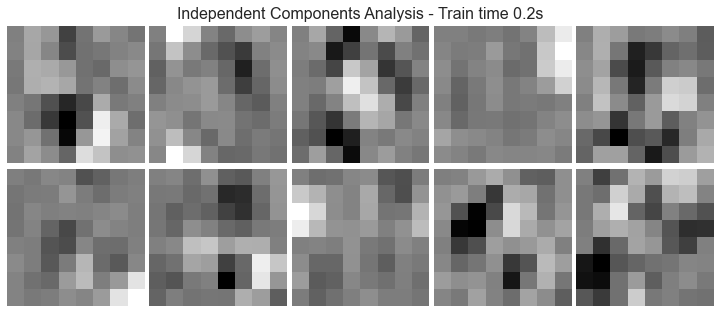

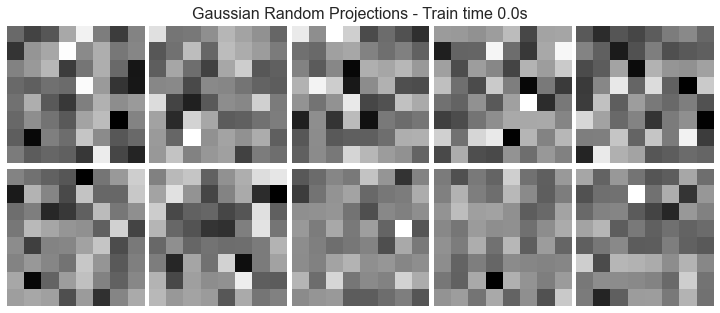

In [193]:
for title, decomposition in decompositions:
    if not title == 'Feature Agglomeration':
        t0 = time()
        decomposition.fit(digits_X)
        train_time = (time() - t0)

        plot_gallery('%s - Train time %.1fs' % (title, train_time),
                     decomposition.components_[:n_components], image_shape=(8,8))

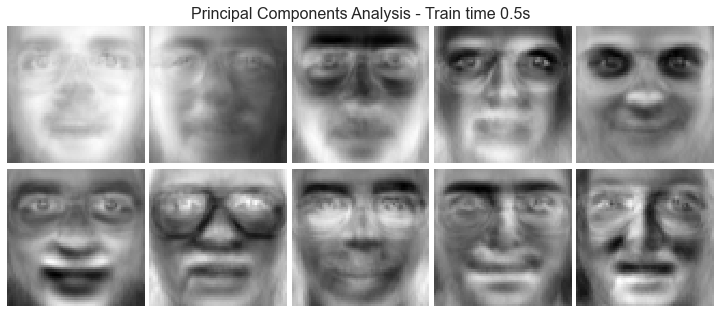

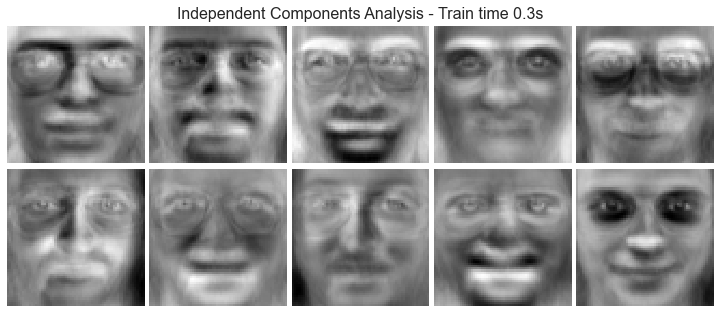

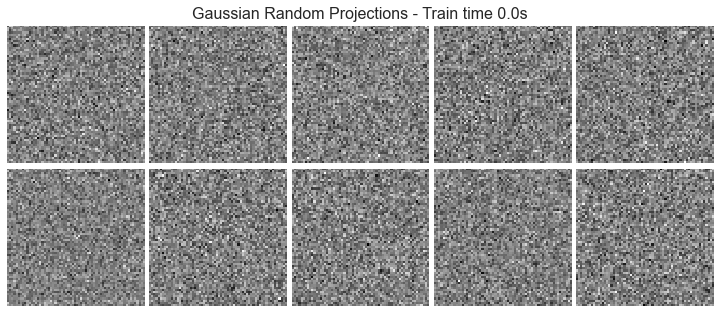

In [194]:
# decompose faces

for title, decomposition in decompositions:
    if not title == 'Feature Agglomeration':
        t0 = time()
        decomposition.fit(faces_X)
        train_time = (time() - t0)

        plot_gallery('%s - Train time %.1fs' % (title, train_time),
                     decomposition.components_[:n_components])

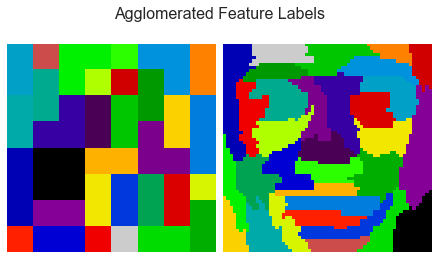

In [167]:
# do feature agglomerations
agglo = FeatureAgglomeration(n_clusters=32, connectivity=grid_to_graph(*digits.images[0].shape))
agglo.fit(digits_X)

plt.suptitle('Agglomerated Feature Labels', size=16)

plt.subplot(1,2,1)
plt.imshow(np.reshape(agglo.labels_, digits.images[0].shape),
           interpolation='nearest', cmap=plt.cm.spectral)
plt.xticks(())
plt.yticks(())

# do feature agglomerations
agglo = FeatureAgglomeration(n_clusters=32, connectivity=grid_to_graph(*faces.images[0].shape))
agglo.fit(faces_X)

plt.subplot(1,2,2)
plt.imshow(np.reshape(agglo.labels_, faces.images[0].shape),
           interpolation='nearest', cmap=plt.cm.spectral)
plt.xticks(())
plt.yticks(())

plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)